In [1]:
%load_ext autoreload
%autoreload 2

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".8"

from typing import Tuple, Dict, Optional

import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from jaxley_mech.channels.benison import Na, Kdr, KA, KCa, CaL, CaN, CaNernstReversal, Leak, CaPumpNS

import jaxley as jx
from jaxley import Compartment


In [2]:
class Compartment(Compartment):
    """
    Extend the Compartment class to include a voltage clamp method.
    """

    def voltage_clamp(
        self, V_hold1: float, V_step: float, T_hold1: int, T_step: int, dt: float,
        V_hold2: Optional[float] = None, T_hold2: Optional[int] = None,
        init_params = None,
    ) -> Tuple[
        Dict[str, jnp.ndarray], Dict[str, Dict[str, jnp.ndarray]]
    ]:
        """
        Apply a voltage clamp to the Compartment and record the resulting currents and state changes.

        Args:
            V_hold1: The first holding voltage in mV.
            V_step: The step voltage in mV.
            T_hold1: The duration of the first holding voltage in time steps.
            T_step: The duration of the step voltage in time steps.
            dt: The time step in ms.
            V_hold2: The second holding voltage in mV (optional, defaults to V_hold1).
            T_hold2: The duration of the second holding voltage in time steps (optional, defaults to T_hold1).

        Returns:
            A tuple containing a dictionary for the currents and a dictionary for the state histories.
        """
        if V_hold2 is None:
            V_hold2 = V_hold1
        if T_hold2 is None:
            T_hold2 = T_hold1

        # Initialize the global state and dictionaries for currents and states
        params = {}
        states = {}
        channel_currents = {
            "hold1": {channel._name: [] for channel in self.channels},
            "step": {channel._name: [] for channel in self.channels},
            "hold2": {channel._name: [] for channel in self.channels},
        }
        channel_states_history = {
            "hold1": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "step": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
            "hold2": {
                channel._name: {state: [] for state in channel.channel_states}
                for channel in self.channels
            },
        }

        for channel in self.channels:
            states.update(channel.channel_states)
            params.update(channel.channel_params)

        if init_params is not None:
            params.update(init_params)
        
        # self.to_jax()

        def update_all_channels(V, dt, phase):
            for channel in self.channels:
                # Compute and store the current for the channel
                current = channel.compute_current(states, V, params)
                if f"{channel.current_name}" in states:
                    states[f"{channel.current_name}"] += current
                else:
                    states[f"{channel.current_name}"] = current
                channel_currents[phase][channel._name].append(current)
            
                # Update the states
                new_states = channel.update_states(states, dt, V, params)
                states.update(new_states)
                for state_key, state_value in new_states.items():
                    channel_states_history[phase][channel._name][state_key].append(state_value)

        # First hold phase
        for _ in range(T_hold1):
            update_all_channels(V_hold1, dt, "hold1")

        # Step phase
        for _ in range(T_step):
            update_all_channels(V_step, dt, "step")

        # Second hold phase
        for _ in range(T_hold2):
            update_all_channels(V_hold2, dt, "hold2")

        # Convert lists to jnp.ndarray and merge all phases
        merged_currents = {}
        for channel_name in channel_currents["hold1"]:
            merged_currents[channel_name] = jnp.concatenate([
                jnp.array(channel_currents["hold1"][channel_name]),
                jnp.array(channel_currents["step"][channel_name]),
                jnp.array(channel_currents["hold2"][channel_name])
            ])

        merged_states_history = {}
        for channel_name in channel_states_history["hold1"]:
            merged_states_history[channel_name] = {}
            for state_name in channel_states_history["hold1"][channel_name]:
                merged_states_history[channel_name][state_name] = jnp.concatenate([
                    jnp.array(channel_states_history["hold1"][channel_name][state_name]),
                    jnp.array(channel_states_history["step"][channel_name][state_name]),
                    jnp.array(channel_states_history["hold2"][channel_name][state_name])
                ])

        return merged_currents, merged_states_history

In [3]:
params = {
    # conductance
    "Na_gNa": 150e-3,
    "Kdr_gKdr": 75e-3,
    "KA_gKA": 50e-3,
    "KCa_gKCa": 2e-3,
    "CaL_gCaL": 2e-3,
    "CaN_gCaN": 1.5e-3,
    "Leak_gLeak": 0.25e-3,

    # reversal potential
    "Na_eNa": 75,
    "Leak_eLeak": -60,
    "eK": -85,
    "eCa": 45,

    "K_KCa": 0.6e-3,

    # pump
    "tau_store": 12.5,
    "Ceq": 0.1e-3,
    "K_pump": 0.1e-3,
    "Cao": 1.8,

    # global
    "length": 5.,
    "radius": 5., 
    "capacitance": 10.0,
    "v": -60,
}

cell = Compartment()

cell.insert(Na())
cell.insert(CaN())
cell.insert(CaL())
cell.insert(Kdr())
cell.insert(KCa())
cell.insert(KA())
cell.insert(CaNernstReversal())
cell.insert(CaPumpNS())
cell.insert(Leak())


for name, param in params.items():
    cell.set(name, param)

cell.init_states()

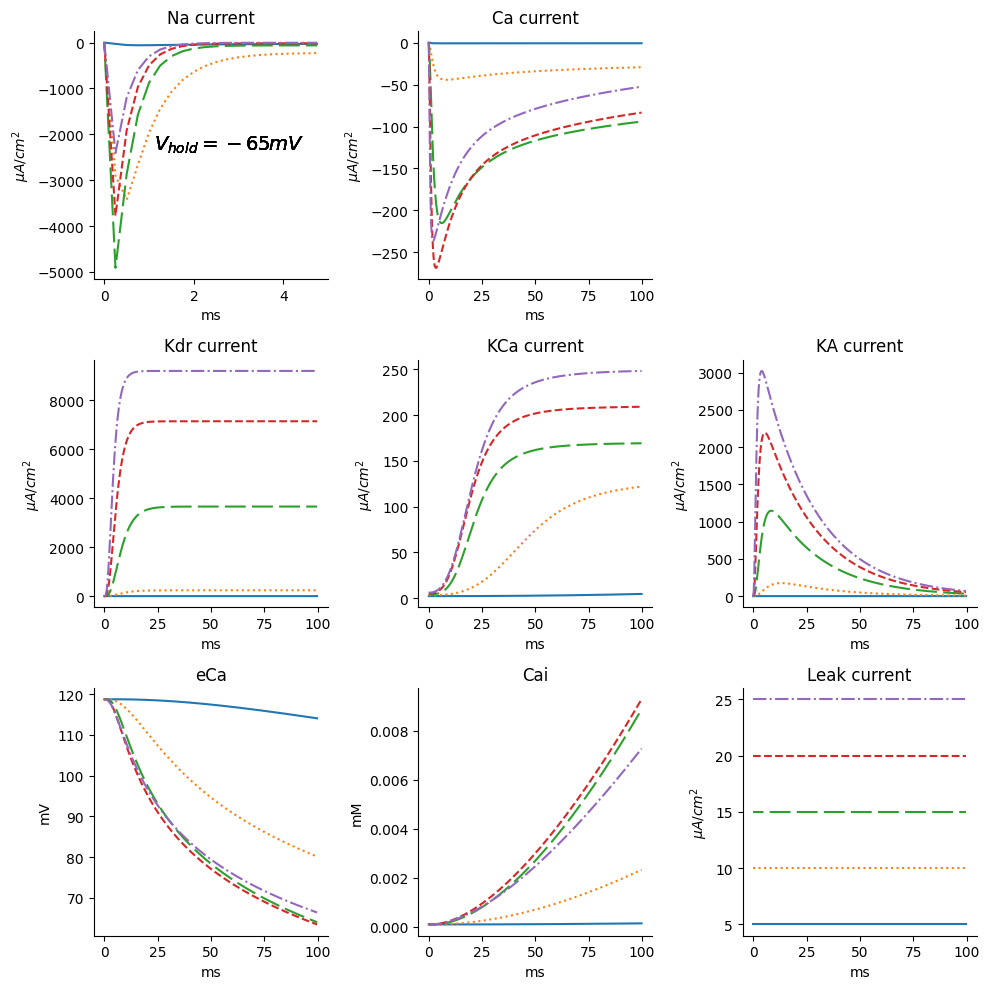

In [4]:
V_hold = -65.0  # mV, the holding potential

dt = 0.25    # ms, the time step for the simulation
t_hold = 100 # ms
t_step = 100 # ms
T_hold = int(t_hold / dt) # points
T_step = int(t_step / dt) # points
fig, ax = plt.subplots(3, 3, figsize=(10,10))
ax = ax.flatten()

linestyles = {
	"-40": "solid",
	"-20": "dotted",
	"0": (5, (10, 3)),
	"20": "dashed",
	"40": "dashdot",
}

# Calculate indices for -20 ms before step and 100 ms after step
pre_step_duration = 0  # ms
post_step_duration = 0  # ms

pre_step_indices = int(pre_step_duration // dt)
post_step_indices = int(post_step_duration // dt)

# Indices for the step period in the merged array
start_step_index = T_hold - pre_step_indices
end_step_index = T_hold + T_step + post_step_indices
time_window = jnp.arange(-pre_step_duration, t_step + post_step_duration, dt)


for V_step in [-40, -20, 0, 20, 40]:
    currents, states = cell.voltage_clamp(V_hold1=V_hold, T_hold1=T_hold, V_step=V_step,  T_step=T_step, dt=dt, init_params=params)

    ax = ax.flatten()
    
    for i, key in enumerate(currents):
        if key == "CaPumpNS":
            ax[i].plot(time_window, states["CaPumpNS"]["Cai"][start_step_index:end_step_index], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            ax[i].set_title("Cai")
            ax[i].set_ylabel("mM")
        elif key == "CaPump":
            ax[i].plot(time_window, states["CaPump"]["Cai"][start_step_index:end_step_index], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            ax[i].set_title("Cai")
            ax[i].set_ylabel("mM")
        elif key == "CaNernstReversal":
            ax[i].plot(time_window, states["CaNernstReversal"]["eCa"][start_step_index:end_step_index], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            ax[i].set_title("eCa")
            ax[i].set_ylabel("mV")
        elif key == "CaN":
            ax[i].plot(time_window, currents["CaL"][start_step_index:end_step_index] + currents["CaN"][start_step_index:end_step_index], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            ax[i].set_title("Ca current") 
            ax[i].set_ylabel(r"$μA/cm^2$")
        elif key == "CaL":
            ax[i].axis("off")
            # continue
        else:
            if key == "Na":
                time_window_na = jnp.arange(-pre_step_duration, 5, dt)
                ax[i].plot(time_window_na, currents[key][start_step_index:start_step_index+int(5/dt)], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            else:
                ax[i].plot(time_window, currents[key][start_step_index:end_step_index], label=f"V={V_step}", linestyle=linestyles[str((V_step))])
            ax[i].set_title(key + " current")
            ax[i].set_ylabel(r"$μA/cm^2$")

        ax[i].set_xlabel("ms")
        ax[i].spines["top"].set_visible(False)
        ax[i].spines["right"].set_visible(False)

    ax[0].annotate(r"$V_{hold}=-65 mV$", xy=(0.9, 0.5), xycoords="axes fraction", ha="right", va="bottom", fontsize=14)

fig.tight_layout()

In [5]:
cell = Compartment()

cell.insert(Na())
cell.insert(CaN())
cell.insert(CaL())
cell.insert(Kdr())
cell.insert(KCa())
cell.insert(KA())
cell.insert(CaNernstReversal())
cell.insert(CaPumpNS())
cell.insert(Leak())

params = {
    # conductance
    "Na_gNa": 150e-3,
    "Kdr_gKdr": 75e-3,
    "KA_gKA": 50e-3,
    "KCa_gKCa": 2e-3,
    "CaL_gCaL": 2e-3,
    "CaN_gCaN": 1.5e-3,
    "Leak_gLeak": 0.25e-3,

    # reversal potential
    "Na_eNa": 75,
    "eK": -85,
    "eCa": 45,
    "Leak_eLeak": -60,

    "K_KCa": 0.6e-3,

    # pump
    "tau_store": 12.5,
    "Ceq": 0.1e-3,
    "K_pump": 0.1e-3,
    "Cao": 1.8,
    "fi": 0.025,

    # global
    "length": 5.,
    "radius": 5., 
    "capacitance": 10.0,
    "v": -60,
}

for name, param in params.items():
    cell.set(name, param)
    
cell.init_states()

# Stimulus.
i_dur = 400
i_delay = 50
i_offset = 0.0
# Duration and step size.
dt = 0.01  # ms
t_max = 600  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

i_amp = 0.01  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
cell.stimulate(current, verbose=False)
to_records = ["v", "iNa", "iK", "iCa", "Cai", "eCa", "iLeak"]
for rec in to_records:
    cell.record(rec, verbose=False)

def parse_s(s, keys):
    return {key: s[i].T[:-1] for (i, key) in enumerate(keys)}

# run the model
s = jx.integrate(cell, delta_t=dt)
s = parse_s(s, to_records)

total_current = s["iNa"] + s["iK"] + s["iCa"] + s["iLeak"]

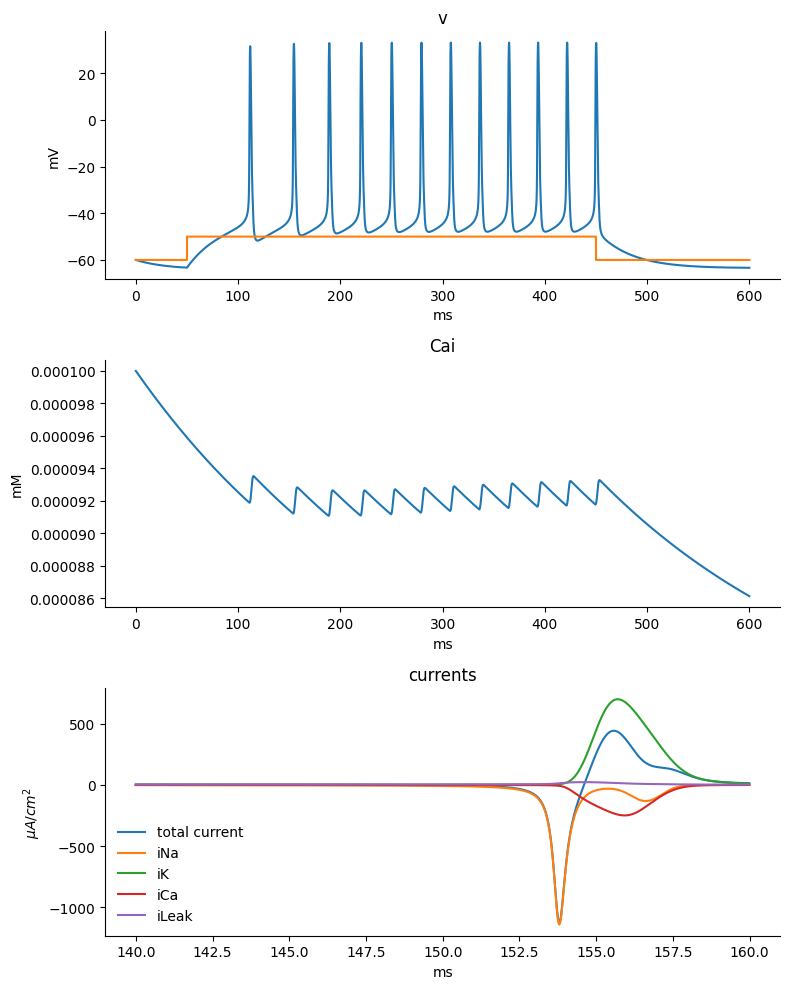

In [6]:
to_plot = ["v", "Cai", "currents"]
mosaic = [[rec] for rec in to_plot]

# figure 1
fig, ax = plt.subplot_mosaic(mosaic, figsize=(8, 10))

for key in ["v", "Cai"]:
    if key == 'Cai':
        ax[key].plot(time_vec, s[key], label=key)
        ax[key].set_ylabel("mM")
    else:
        ax[key].plot(time_vec, s[key], label=key)
        ax[key].set_ylabel("mV")
    # ax[key].set_ylabel(r"$μA/cm^2$")
    ax[key].set_xlabel("ms")
    ax[key].spines["top"].set_visible(False)
    ax[key].spines["right"].set_visible(False)
    ax[key].set_title(key)

ax["v"].plot(time_vec, (current * 1000 - 60), label="i")

ax["currents"].plot(time_vec[int(140/dt):int(160/dt)], total_current[int(140/dt):int(160/dt)], label="total current")
ax["currents"].plot(time_vec[int(140/dt):int(160/dt)], s["iNa"][int(140/dt):int(160/dt)], label="iNa")
ax["currents"].plot(time_vec[int(140/dt):int(160/dt)], s["iK"][int(140/dt):int(160/dt)], label="iK")
ax["currents"].plot(time_vec[int(140/dt):int(160/dt)], s["iCa"][int(140/dt):int(160/dt)], label="iCa")
ax["currents"].plot(time_vec[int(140/dt):int(160/dt)], s["iLeak"][int(140/dt):int(160/dt)], label="iLeak")
# ax["currents"].plot(time_vec[int(140/dt):int(160/dt)], s["iKCa"][int(140/dt):int(160/dt)], label="iKCa")
ax["currents"].spines["top"].set_visible(False)
ax["currents"].spines["right"].set_visible(False)
ax["currents"].set_title("currents")
ax["currents"].set_xlabel("ms")
ax["currents"].set_ylabel(r"$μA/cm^2$")
ax["currents"].legend(frameon=False)
fig.tight_layout()

## Notes

- Here, we only use the non-spatial calcium dynamics in this model, the spatial model is yet to be implemented.
- The rate constant of the Kdr channel in the paper is very liekly wrong, as the steady state of the gate is so different from other publications. I take the liberty to fix it.
- In the paper, the conductance of the KCa channel used the fourth power sigmoid function, which results in very small conductance changes. I use the 2nd power instead (as the one in FM97).
- The gKCa mainly controls the spike frequency. See the next figure.


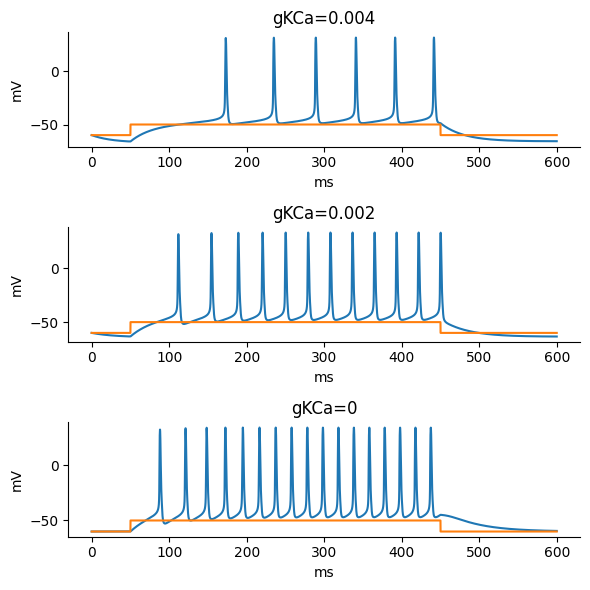

In [7]:
cell = Compartment()

cell.insert(Na())
cell.insert(CaN())
cell.insert(CaL())
cell.insert(Kdr())
cell.insert(KCa())
cell.insert(KA())
cell.insert(CaNernstReversal())
cell.insert(CaPumpNS())
cell.insert(Leak())

params = {
    # conductance
    "Na_gNa": 150e-3,
    "Kdr_gKdr": 75e-3,
    "KA_gKA": 50e-3,
    "KCa_gKCa": 2e-3,
    "CaL_gCaL": 2e-3,
    "CaN_gCaN": 1.5e-3,
    "Leak_gLeak": 0.25e-3,

    # reversal potential
    "Na_eNa": 75,
    "eK": -85,
    "eCa": 45,
    "Leak_eLeak": -60,

    "K_KCa": 0.6e-3,

    # pump
    "tau_store": 12.5,
    "Ceq": 0.1e-3,
    "K_pump": 0.1e-3,
    "Cao": 1.8,
    "fi": 0.025,

    # global
    "length": 5.,
    "radius": 5., 
    "capacitance": 10.0,
    "v": -60,
}

for name, param in params.items():
    cell.set(name, param)

# Stimulus.
i_dur = 400
i_delay = 50
i_offset = 0.0
# Duration and step size.
dt = 0.01  # ms
t_max = 600  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

i_amp = 0.01  # nA
current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
cell.stimulate(current, verbose=False)  


mosaic = """
1
2
3
"""
fig, ax = plt.subplot_mosaic(mosaic, figsize=(6, 6))

for i, gkca in enumerate([4e-3, 2e-3, 0]):

    cell.set("KCa_gKCa", gkca)
    cell.init_states()

    cell.record("v", verbose=False)

    # run the model
    s = jx.integrate(cell, delta_t=dt)
    s = parse_s(s, ["v"])

    ax[str(i+1)].plot(time_vec, s["v"], label=key)
    ax[str(i+1)].set_ylabel("mV")
    ax[str(i+1)].set_xlabel("ms")
    ax[str(i+1)].spines["top"].set_visible(False)
    ax[str(i+1)].spines["right"].set_visible(False)
    ax[str(i+1)].set_title(f"gKCa={gkca}")

    ax[str(i+1)].plot(time_vec, (current * 1000 - 60), label="i")

fig.tight_layout()


In [8]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-05-29 14:08:13CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.0.1

jaxley    : 0.0.0
matplotlib: 3.8.3
jax       : 0.4.26

Watermark: 2.4.3

